# Clustering California Housing with K-means
### By Ali Shannon

I am looking into the housing crisis in the state of California. This dataset is kindly provided by [Kaggle](https://www.kaggle.com/camnugent/california-housing-prices), visit their website for free datasets for 


"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

I will attempt to cluster the dataset using K-Means, the most popular clustering algorithm in machine learning. The idea here is to find the best number of clusters that minimizes the objective function I declare below.

---

## 1. PRE-PROCESSING THE DATA

Here, I will show some statistical information and do some preprocessing before applying machine learning algorithms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

np.random.seed(42)

df = pd.read_csv('housing.csv')

df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Basic distributions for each column.

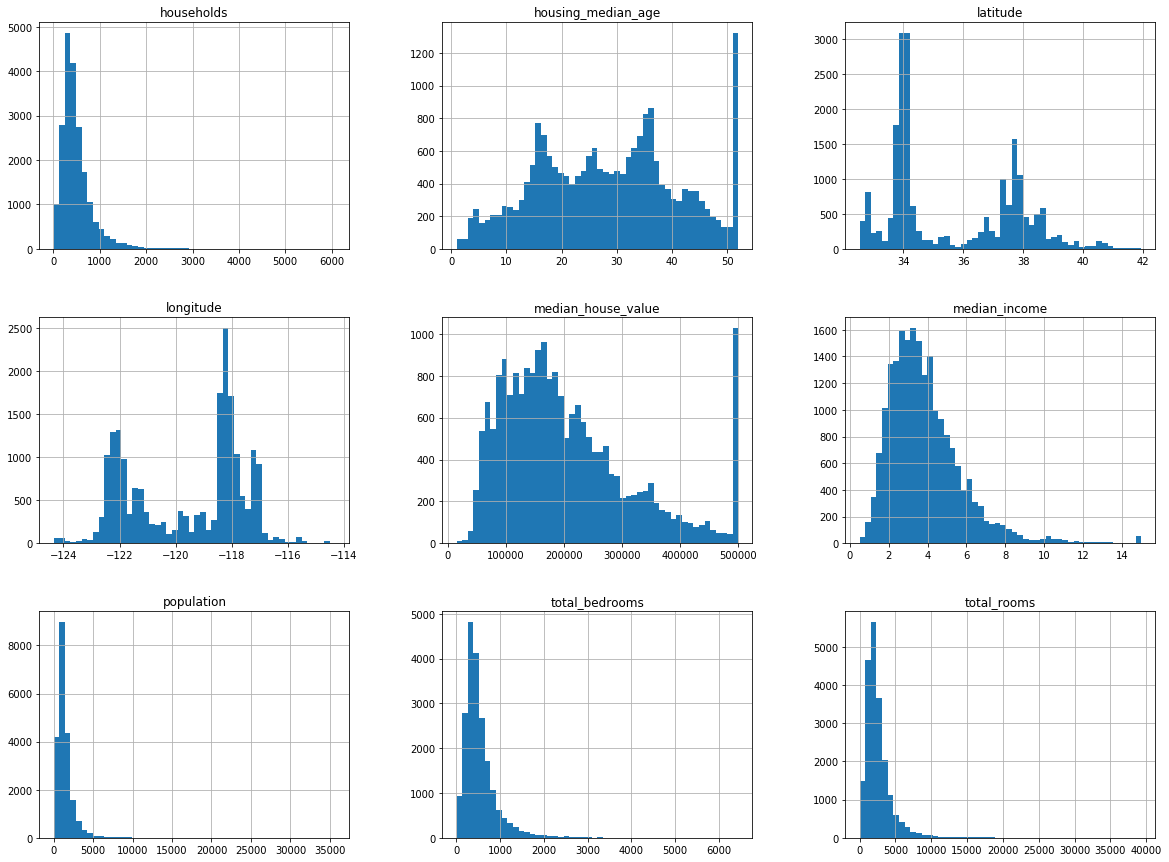

In [2]:
df.hist(bins=50, figsize=(20,15));
plt.show()

Notice the latitude and longitude of density of homes near Los Angeles and San Francisco areas. This might be useful for our clustering algorithm.

---

This is an image showing the distribution of houses from the dataset. The size of the circles indicate the population density and the color indicates the median house value.

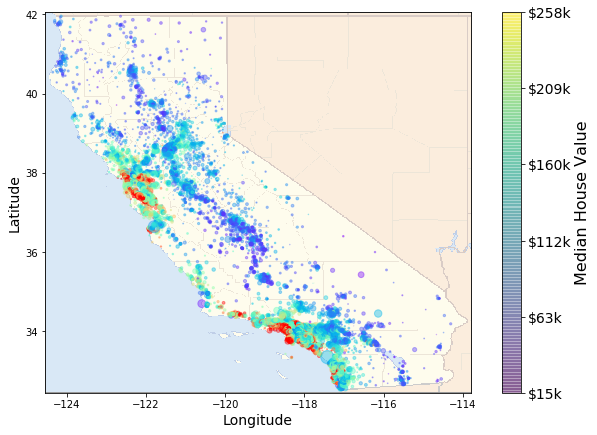

In [3]:
cali_image_url = 'https://upload.wikimedia.org/wikipedia/commons/1/1b/California_Locator_Map.PNG'
cali = plt.imread(cali_image_url)

# plot the populations with density and colors
ax = df.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
    s = df["population"]/200, figsize = (11,7),
    c = "median_house_value", cmap = plt.get_cmap("rainbow"), colorbar = False,
    sharex = True)

# show the image of California in the back
plt.imshow(cali, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)


plt.show()

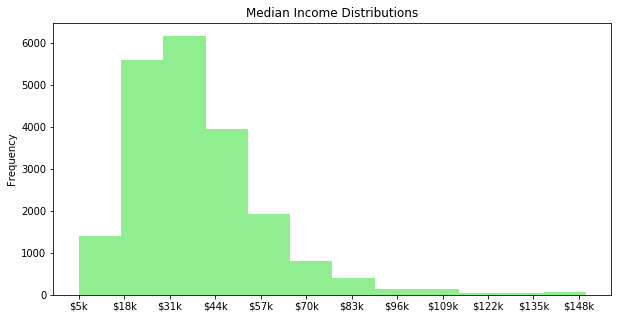

In [4]:
ran = np.arange(df['median_income'].min() ,df['median_income'].max(), 1.3)
ticks = ['${:.0f}k'.format(v*10) for v in ran]


df["median_income"].plot.hist(bins = len(ran), figsize = [10,5], color = 'lightgreen')
plt.xticks(ran, ticks)
plt.title('Median Income Distributions')
plt.show()

Find the data type of each column so we can figure out which columns we need to convert to dummies.

In [5]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [6]:
df = pd.get_dummies(df)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


Converted all fields into float or int so now we can check for missing values.

In [7]:
# check for missing values
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/df.shape[0] # normalize
print(f'{missing_values *100} %')

total_bedrooms    1.002907
dtype: float64 %


About 1% of the total_bedrooms feature is missing. Let's fill out all missing values with the median for each field.

In [8]:
for feature in df.columns:
    df[feature].fillna(df[feature].median(), inplace=True)

In [9]:
df.isnull().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

- - -

## 2. IMPLEMENTING K-MEANS

The `KMeans` function takes two arguments:

- `X` is the $m\times n$ matrix that is our data.

- `k` is the number of clusters to start with.

This function will start by making `k` centroids with values randomly extracted from feature space (n-dimensional vectors).
For each instance, it will calculate the Euclidean distance to each one of the centroids and assign the closest centroid to this instance.
Then it will update the location of the centroid to the average distance of the points that belong to it.

$$\text{dist}(\textbf{x}^{[i]}, \textbf{c}^{[j]}) = \sqrt{\sum_{k=1}^{n} \left [ x^{[i]}_{k} - c^{[j]}_{k} \right ] ^{2}} = \| \textbf{x}^{[i]} - \textbf{c}^{[j]} \|$$

$$\text{for }\textit{i} \in \textit{[0, m],} \text{ for }\textit{j} \in \textit{[0, K]}$$

This function returns two arguments:

- `distances` the distances matrix where each sample (or instance) is included with the distances to each centroid and the closest centroid.

- `centroids` a dictionary with the location of each centroid indexed from _0 to k-1_.

In [10]:
def KMeans(X, k):

    # initialize random centroids
        
    mins = X.min().values
    maxs = X.max().values
    
    centroids = {
        i: [np.random.randint(mins[t], maxs[t]) for t in range(len(mins))]
        for i in range(k)
    }
        
    # assign points by distance
            
    distances = []
    
    for row in X.values:
        arr = []
        for j in centroids:
            arr.append(
                np.linalg.norm(row - centroids[j])
            )
        arr.append(np.argmin(arr)) 
        distances.append(arr) 
        
    # update centroids
    
    sums = 0
        
    for c in range(k):
        indices = [distances.index(row) for row in distances if row[-1] == c]
        centroids[c] = X.iloc[indices].mean().values
    
    # update distances
    
    distances = []
    
    for row in X.values:
        arr = []
        for j in centroids:
            arr.append(
                np.linalg.norm(row - centroids[j])
            )
        arr.append(np.argmin(arr)) 
        distances.append(arr) 
    
    return distances, centroids

The `J(X, K)` is the evaluation or objective function. This is intended to find the number of clusters that minimizes the rate of change of the objective function. Here I am using the elbow method to find the least number of clusters.

In [11]:
def J(X, K):
    
    res = []
    for k in range(1, K + 1):
        arr = []
        dist, _ = KMeans(X, k)
        for c in range(k): # for each point
            di = [row[c] for row in dist if row[-1] == c]
            arr.append(np.sum(di))
        res.append(np.min(arr))
    
    return res

Attempt to find an elbow with 7 clusters.

In [12]:
max_k = 7
res = J(df, max_k)

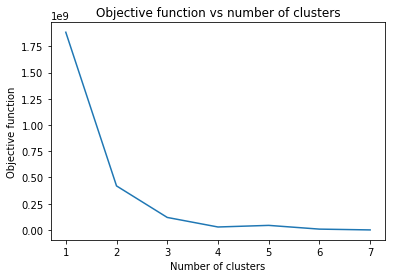

In [13]:
plt.plot(np.arange(1, max_k+1), res);
plt.xlabel('Number of clusters')
plt.title('Objective function vs number of clusters')
plt.ylabel('Objective function')
plt.show()

Two or three clusters should have the optimal number of clusters.

- - -
## 3. CLUSTERING HOUSING INTO REGIONS

Here I attempt to split California into three regions. This assessment is based on the elbow method as described above. I will use those functions to split the region into three clusters.

In [14]:
k = 3

dist, cent = KMeans(df, k)

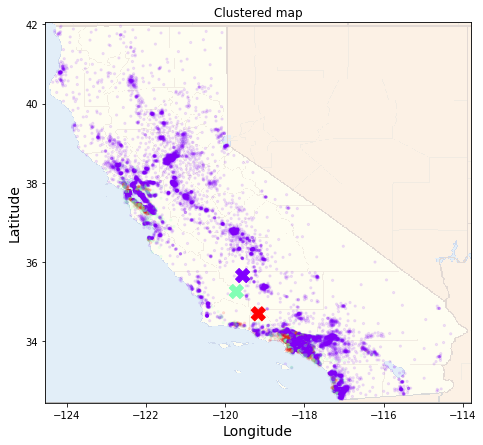

In [15]:
x, y = [cent[i][0] for i in cent], [cent[i][1] for i in cent]

df.plot(kind="scatter", x = "longitude", y = "latitude", alpha = 0.1,
    s = 5, figsize = (10,7), colorbar = False,
    c = np.array(dist)[:,-1], cmap = plt.get_cmap("rainbow"),
    sharex=False)

plt.scatter(x, y, marker='X', alpha = 1.0, c = [u for u in cent], cmap = plt.get_cmap("rainbow"), s = 200)

plt.imshow(cali, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.3)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.title('Clustered map')

plt.show()

Geometrically they seem to overlap and the purple one dominates the others due to the hue. A plot of each cluster and its regions might look better.

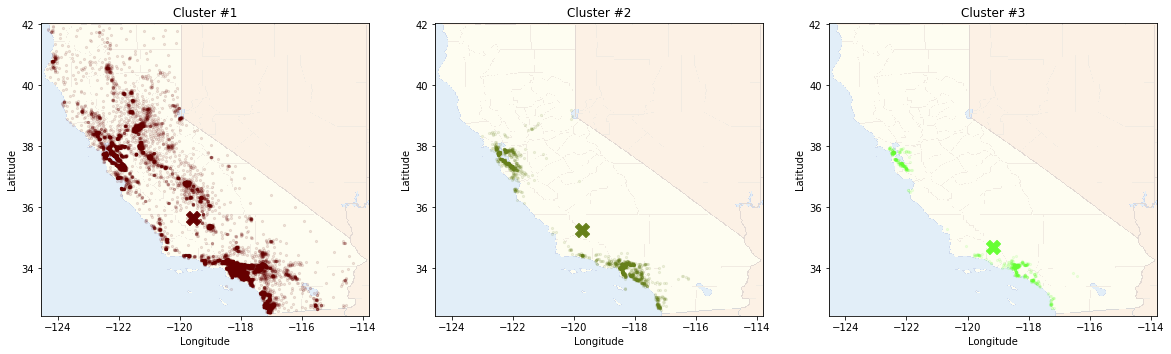

In [16]:
fig = plt.figure(figsize=(20, 30))


for c in range(k):

    indices = [dist.index(row) for row in dist if row[-1] == c]
    
    colormap = [[0.4, c / (k-1) , 0.2*(c/(k-1))]]

    
    ax = fig.add_subplot(1, k, c+1)
    ax.scatter(x = df['longitude'].iloc[indices], y = df['latitude'].iloc[indices], alpha = 0.1,
        s = 5, c = colormap)


    ax.scatter(x[c], y[c], marker='X', alpha = 1.0, c = colormap, s = 200)

    ax.imshow(cali, extent=[-124.55, -113.80, 32.45, 42.05], alpha = 0.3)
    ax.set(ylabel = "Latitude", xlabel = "Longitude", title = "Cluster #{}".format(c+1))

plt.show()

Now we see how the clustering algorithm sees the differences. It appears that the housing prices have been a major category in splitting the dataset. 

In [17]:
from IPython import display

for c in range(k):
    indices = [dist.index(row) for row in dist if row[-1] == c]
    s = df.iloc[indices, :].describe()
    print('\n\nCluster #{}'.format(c+1))
    display.display(s)



Cluster #1


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,17694.000000,17694.000000,17694.000000,17694.000000,17694.00000,17694.000000,17694.000000,17694.000000,17694.000000,17694.000000,17694.000000,17694.000000,17694.000000,17694.000000
mean,-119.526910,35.674078,28.064429,2572.460891,536.90347,1454.904883,498.695773,3.465878,169740.007686,0.426472,0.362496,0.000113,0.095230,0.115689
std,2.001907,2.178021,12.380323,2135.144918,419.82636,1147.392494,381.603075,1.371553,72483.137148,0.494578,0.480734,0.010631,0.293541,0.319861
min,-124.350000,32.540000,1.000000,2.000000,2.00000,5.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.580000,33.930000,18.000000,1414.000000,298.00000,804.000000,279.000000,2.437500,111300.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.500000,34.280000,28.000000,2067.500000,435.00000,1193.000000,408.000000,3.284500,162500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-117.970000,37.740000,36.000000,3071.000000,642.00000,1765.000000,602.000000,4.314000,223275.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.00000,35682.000000,6082.000000,15.000100,337400.000000,1.000000,1.000000,1.000000,1.000000,1.000000




Cluster #2


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000
mean,-119.859576,35.421595,31.699956,2796.692886,506.088378,1203.343791,477.836942,5.861218,408589.439240,0.538224,0.053027,0.001326,0.204154,0.203270
std,2.009217,1.860800,13.424763,2426.756644,411.247847,1064.682974,384.610784,2.321553,54507.770156,0.498647,0.224137,0.036394,0.403171,0.402521
min,-123.000000,32.630000,2.000000,8.000000,1.000000,3.000000,1.000000,0.499900,337500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-122.120000,33.925000,21.000000,1530.000000,270.000000,629.000000,255.000000,4.165850,359500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.170000,33.000000,2265.000000,417.000000,973.000000,395.000000,5.649300,396200.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.230000,37.500000,42.000000,3327.000000,620.000000,1461.500000,588.000000,7.211650,451200.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,-116.250000,39.190000,52.000000,37937.000000,5471.000000,16122.000000,5189.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000




Cluster #3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.0,683.000000,683.000000
mean,-119.717921,35.234876,33.396779,3742.475842,637.051245,1399.101025,593.310395,7.762042,499980.181552,0.544656,0.024890,0.0,0.209370,0.221083
std,1.941827,1.778820,12.532624,2194.118104,419.747203,842.730766,380.548166,3.159902,378.165819,0.498367,0.155905,0.0,0.407157,0.415281
min,-122.570000,32.690000,2.000000,1540.000000,226.000000,349.000000,169.000000,0.702500,491200.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,-122.130000,34.010000,24.000000,2465.000000,380.000000,904.000000,362.000000,5.196100,500001.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,-118.480000,34.130000,33.000000,3095.000000,511.000000,1152.000000,480.000000,7.629000,500001.000000,1.000000,0.000000,0.0,0.000000,0.000000
75%,-118.340000,37.430000,43.000000,4165.000000,746.500000,1551.000000,695.000000,10.041350,500001.000000,1.000000,0.000000,0.0,0.000000,0.000000
max,-116.430000,37.980000,52.000000,18132.000000,5419.000000,7431.000000,4930.000000,15.000100,500001.000000,1.000000,1.000000,0.0,1.000000,1.000000


The clusters seem to divide California houses by median house values, median income, and ocean proximity. This is interesting since we clearly see that houses closer to the industrial areas such as Los Angeles and San Francisco have a much higher value.